In [169]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import simulate
import seaborn as sns
import calculate_return as cr
import matplotlib
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows', 1000)
plt.style.use('seaborn')

Fetching Data

In [2]:
ports = cr.fetch_returns(sim_type = 'garch', random_seeds = range(10000))

Calculating Quantiles

In [19]:
y = ports[["dual_phase","single_phase","100","9050"]].sort_index()
y = y.loc[(slice(None), '2070-01-01'),:]
quantile=y.quantile([0.05,0.1,0.25,0.5,0.75,0.9,0.99],axis=0).round(decimals=1)
quantile['dual_phase']=quantile['dual_phase'].apply('{:,}'.format)
quantile['100']=quantile['100'].apply('{:,}'.format)
quantile['single_phase']=quantile['single_phase'].apply('{:,}'.format)
quantile['9050']=quantile['9050'].apply('{:,}'.format)
print(quantile)

         dual_phase  single_phase           100         9050
0.050     401,702.0     445,289.8     450,978.7    654,314.7
0.100     792,156.3     827,907.5     701,323.8    834,364.2
0.250   1,578,737.5   1,619,017.0   1,253,909.5  1,236,068.2
0.500   3,005,684.8   2,996,312.4   2,191,834.0  1,965,585.5
0.750   5,058,007.3   4,923,404.0   3,555,740.8  3,018,214.8
0.900   7,912,987.8   7,578,566.0   5,274,542.4  4,401,267.8
0.990  15,870,376.0  14,654,406.6  10,353,666.2  8,438,378.3


Plottin Data

In [13]:
plt.rc('font', size=10)          # controls default text sizes
plt.rc('axes', titlesize=13)     # fontsize of the axes title
plt.rc('axes', labelsize=13)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('figure', titlesize=13)  # fontsize of the figure title

Density plots

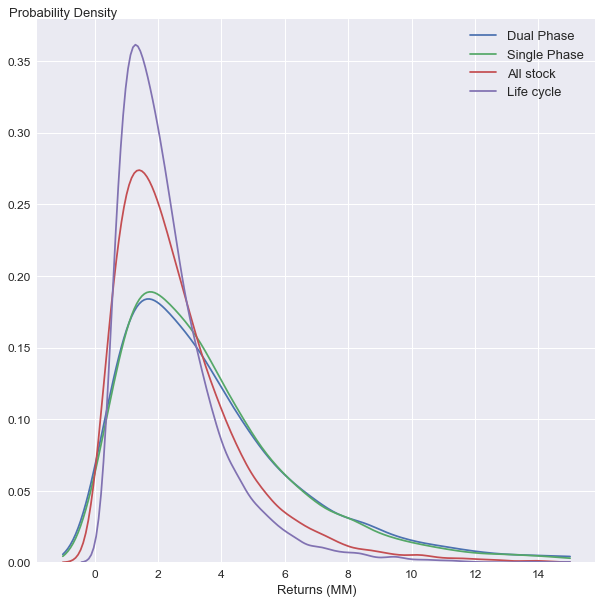

In [21]:
fige=y.copy()
fige['dual_phase'] = fige['dual_phase'].div(1000000) #Convert into millions
fige['single_phase'] = fige['single_phase'].div(1000000) #Convert into millions
fige['100'] = fige['100'].div(1000000) #Convert into millions
fige['9050'] = fige['9050'].div(1000000) #Convert into millions
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.kdeplot(data=fige['dual_phase'],clip=(-1, 15),label='Dual Phase')
sns.kdeplot(data=fige['single_phase'],clip=(-1, 15),label='Single Phase')
sns.kdeplot(data=fige['100'],clip=(-1, 15),label='All stock')
sns.kdeplot(data=fige['9050'],clip=(-1, 15),label='Life cycle')
ax.set_xlabel('Returns (MM)') 
ax.ticklabel_format(style='plain', axis='x')
ax.set_ylabel('Probability Density',loc='top', rotation = 0, labelpad = -110)
plt.legend()
plt.savefig("Empirical/density.png", bbox_inches = 'tight', pad_inches = 0.1)

Boxplots

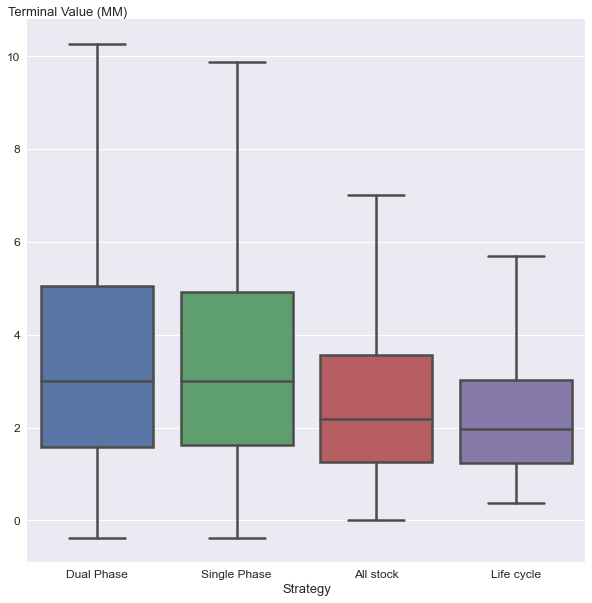

In [15]:
x = ports[["dual_phase","single_phase","100","9050"]]
x = x.rename(columns={'dual_phase':'Dual Phase','single_phase':'Single Phase','100': 'All stock', '9050': 'Life cycle'})
x = x.loc[(slice(None), '2070-01-01'),:]
x = pd.melt(x)
x['value'] = x['value'].div(1000000) #Convert into millions
f, ax = plt.subplots(figsize=(10,10))
ax = sns.boxplot(x='variable',y='value',data=x,showfliers = False,linewidth=2.5)
ax.set_ylabel("Terminal Value (MM)", rotation=0, loc='top', labelpad=-120) 
plt.xlabel("Strategy")
plt.ticklabel_format(style='plain', axis='y',useOffset=True, )
plt.savefig("Empirical/boxplot.png", bbox_inches = 'tight', pad_inches = 0.1)

### Examining Default risk

Finding defaulted investors and the timeseries for them

In [163]:
z = ports[['savings','cash','total_debt','pv_u','tv_u','dual_phase','single_phase','SU_debt','Nordnet_debt','market_returns']]
zz = z.loc[(slice(None), '2070-01-01'),:]
zzz = zz[zz['tv_u'] <= 0].reset_index()
defaulted=zzz['random_state'].tolist()
defaulted_df=z.loc[defaulted,:]
data=defaulted_df[['dual_phase','total_debt','market_returns', 'tv_u','pv_u']].reset_index().set_index('period')
data=data.groupby(['period']).mean()
#print number of defaulted
print(len(defaulted)) 
#Laver cumulative mean returns for defaulted
cum_return=data[['market_returns']].reset_index()
cum_return['cumulative_returns']=0
cum_return.iloc[0,2]=1
for i in range(1, 600):
        cum_return.iloc[i, 2] = cum_return.iloc[i-1, 2]+cum_return.iloc[i, 1]  
cum_return=cum_return.set_index('period')  

112


Plotting defaulted investors

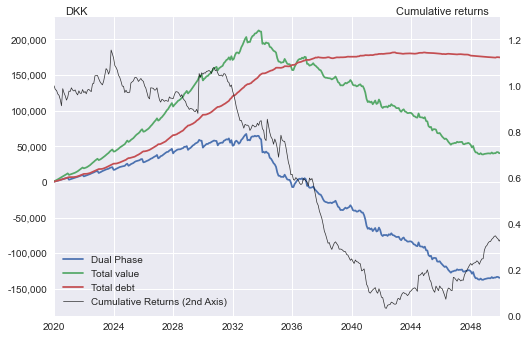

In [175]:
fig = plt.figure()
ax = fig.add_subplot(111)

lns1 = ax.plot(data[['dual_phase']], label='Dual Phase')
lns2 = ax.plot(data[['tv_u']], label='Total value')
lns3 = ax.plot(data[['total_debt']], label='Total debt')
ax2 = ax.twinx()
lns4 = ax2.plot(cum_return[['cumulative_returns']],color='k',alpha=0.8,linewidth=0.7, label="Cumulative Returns (2nd Axis)")

# added these three lines
lns = lns1+lns2+lns3+lns4
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=3)

ax2.grid(b=None)
ax1.set_xlabel('period')
ax.set_ylabel('DKK', rotation=0, loc='top', labelpad=-80)
ax2.set_ylabel('Cumulative returns ', rotation=0, loc='top', labelpad=-30, va='bottom')
ax2.set_ylim(0,1.3)
ax.set_xlim('2020-01-01','2050-01-01')
ax.set_axisbelow(True)
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.show()

fig.savefig("Empirical/Defaulted.png", bbox_inches = 'tight', pad_inches = 0.1)

